## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Feb  8 03:57:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 4 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.90 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (11265/11265), done.
/content/yolov5
HEAD is now at fbe67e46 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


In [4]:
#follow the link below to get your download code from from Roboflow

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="E4Ey4znZECy2TrjfZMSY")
project = rf.workspace("computer-vision-xiyu1").project("coral-life-forms-detection")
dataset = project.version(3).download("yolov5")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coral-Life-Forms-Detection-3 in yolov5pytorch:: 100%|██████████| 1726/1726 [00:00<00:00, 7434.11it/s]


In [5]:
%cd /content/yolov5

/content/yolov5


In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Branching
- Encrusting
- Foliose
- Massive
- Mushroom
- Submassive
- Tabulate
nc: 7
roboflow:
  license: CC BY 4.0
  project: coral-life-forms-detection
  url: https://universe.roboflow.com/computer-vision-xiyu1/coral-life-forms-detection/dataset/3
  version: 3
  workspace: computer-vision-xiyu1
test: ../test/images
train: Coral-Life-Forms-Detection-3/train/images
val: Coral-Life-Forms-Detection-3/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [13]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-02-08 04:29:28.660040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 04:29:28.660104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 04:29:28.661531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 04:29:29.728784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Coral-Life-Forms-Detection-3/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False,

# Evaluate Custom YOLOv5 Detector Performance

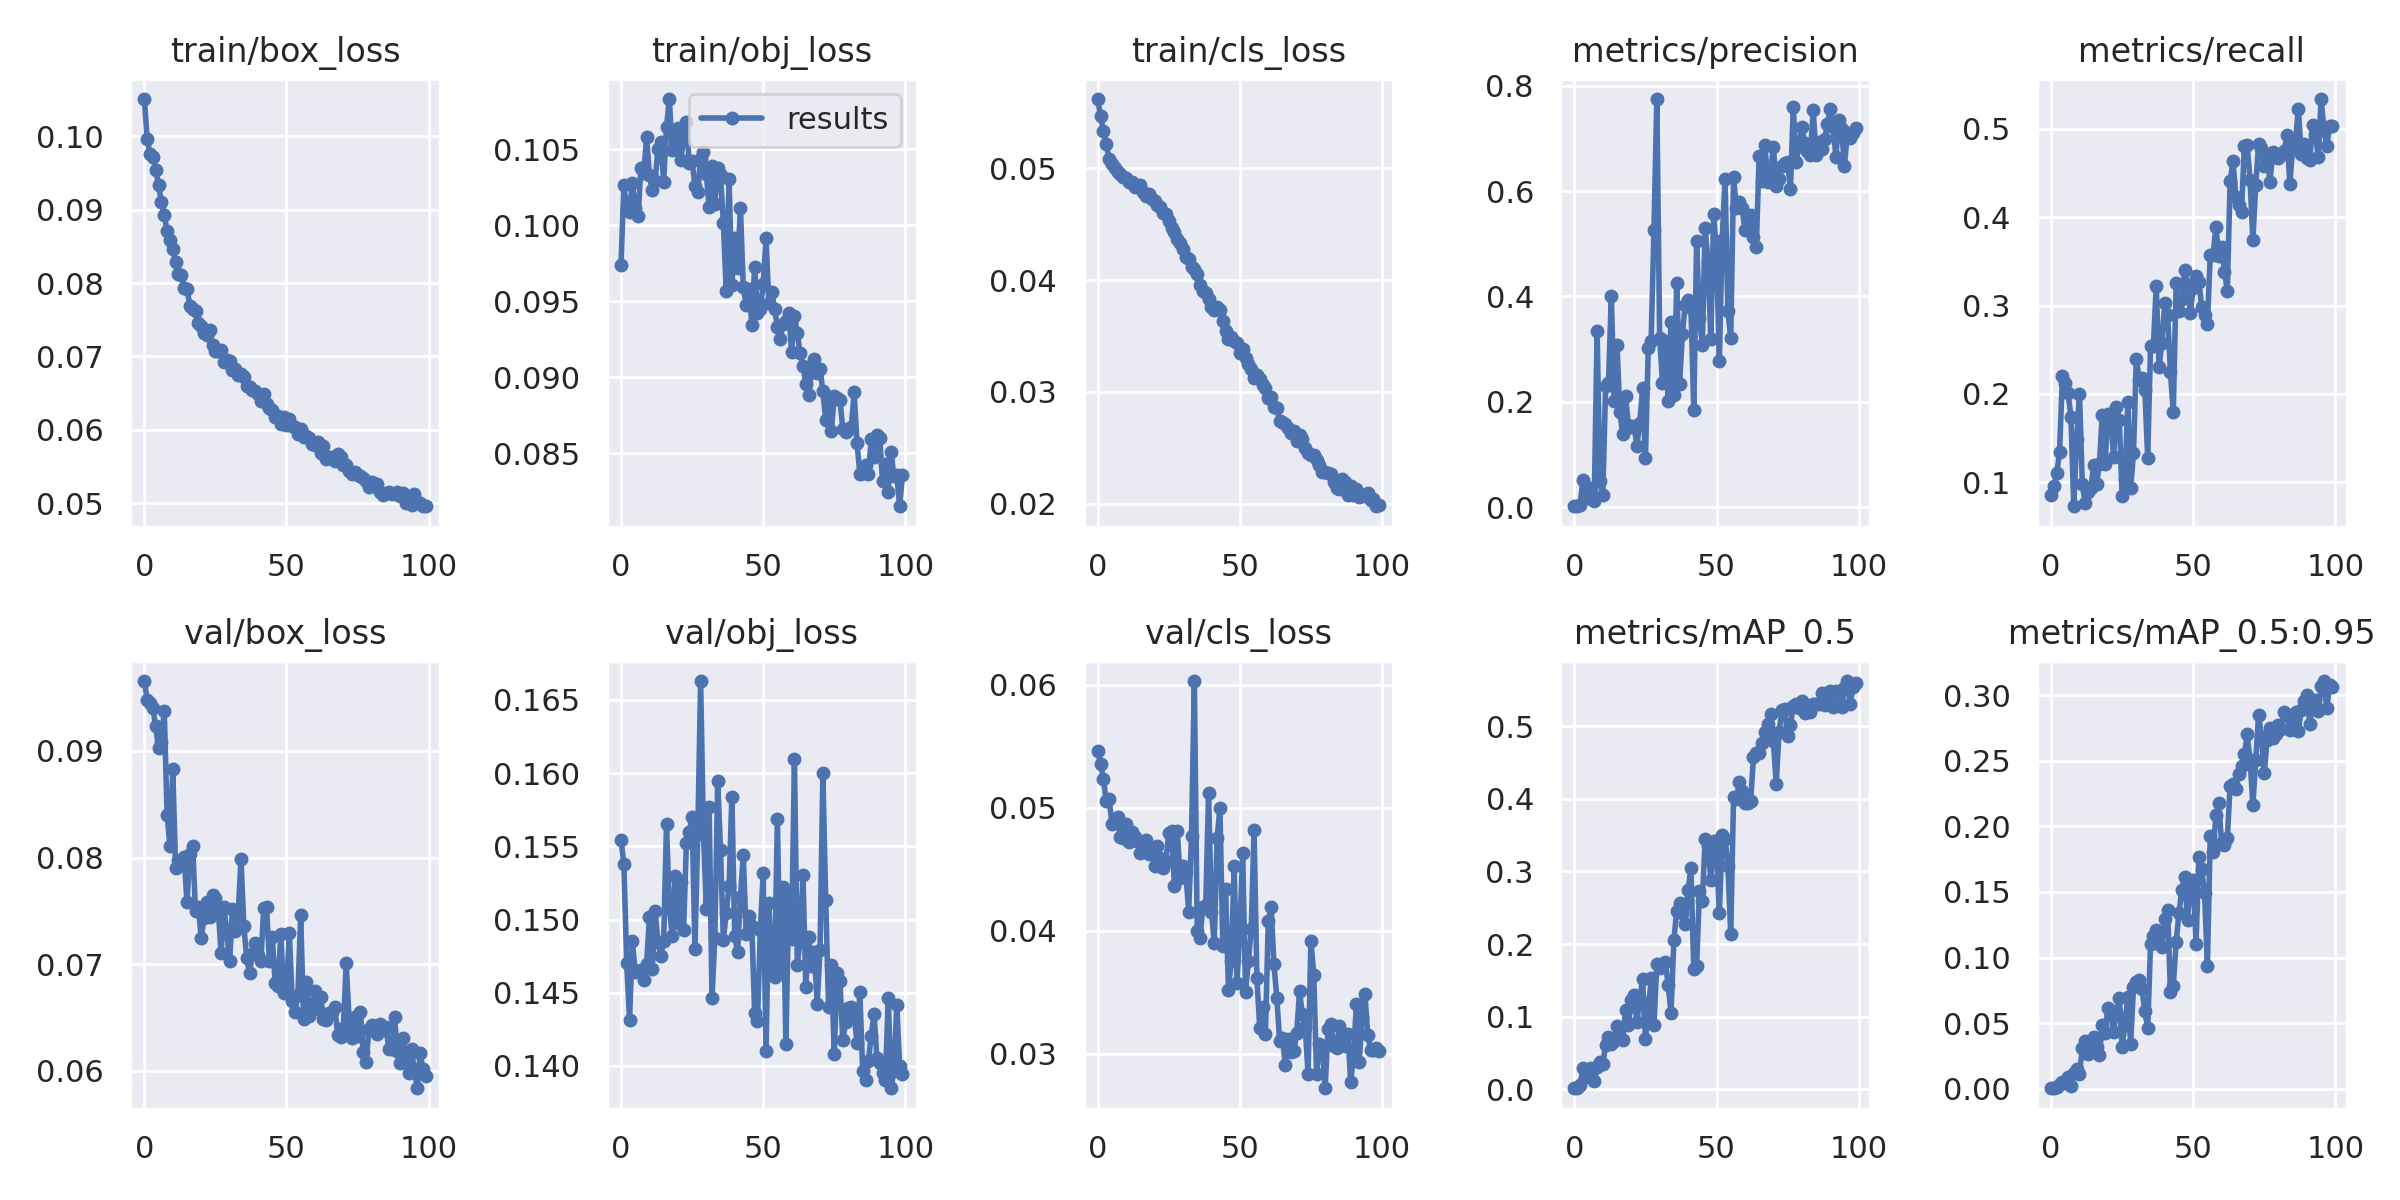

In [14]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [30]:
!python val.py --data {dataset.location}/data.yaml --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.pt --img 416

val: data=/content/yolov5/Coral-Life-Forms-Detection-3/data.yaml, weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e46 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7262700 parameters, 0 gradients, 16.8 GFLOPs
val: Scanning '/content/yolov5/Coral-Life-Forms-Detection-3/valid/labels.cache' images and labels... 33 found, 0 missing, 0 empty, 0 corrupt: 100% 33/33 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 2/2 [00:03<00:00,  1.72s/it]
                 all         33        316      0.711      0.499      0.562       0.31
           Branching 

### Visualize Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.


GROUND TRUTH TRAINING DATA:


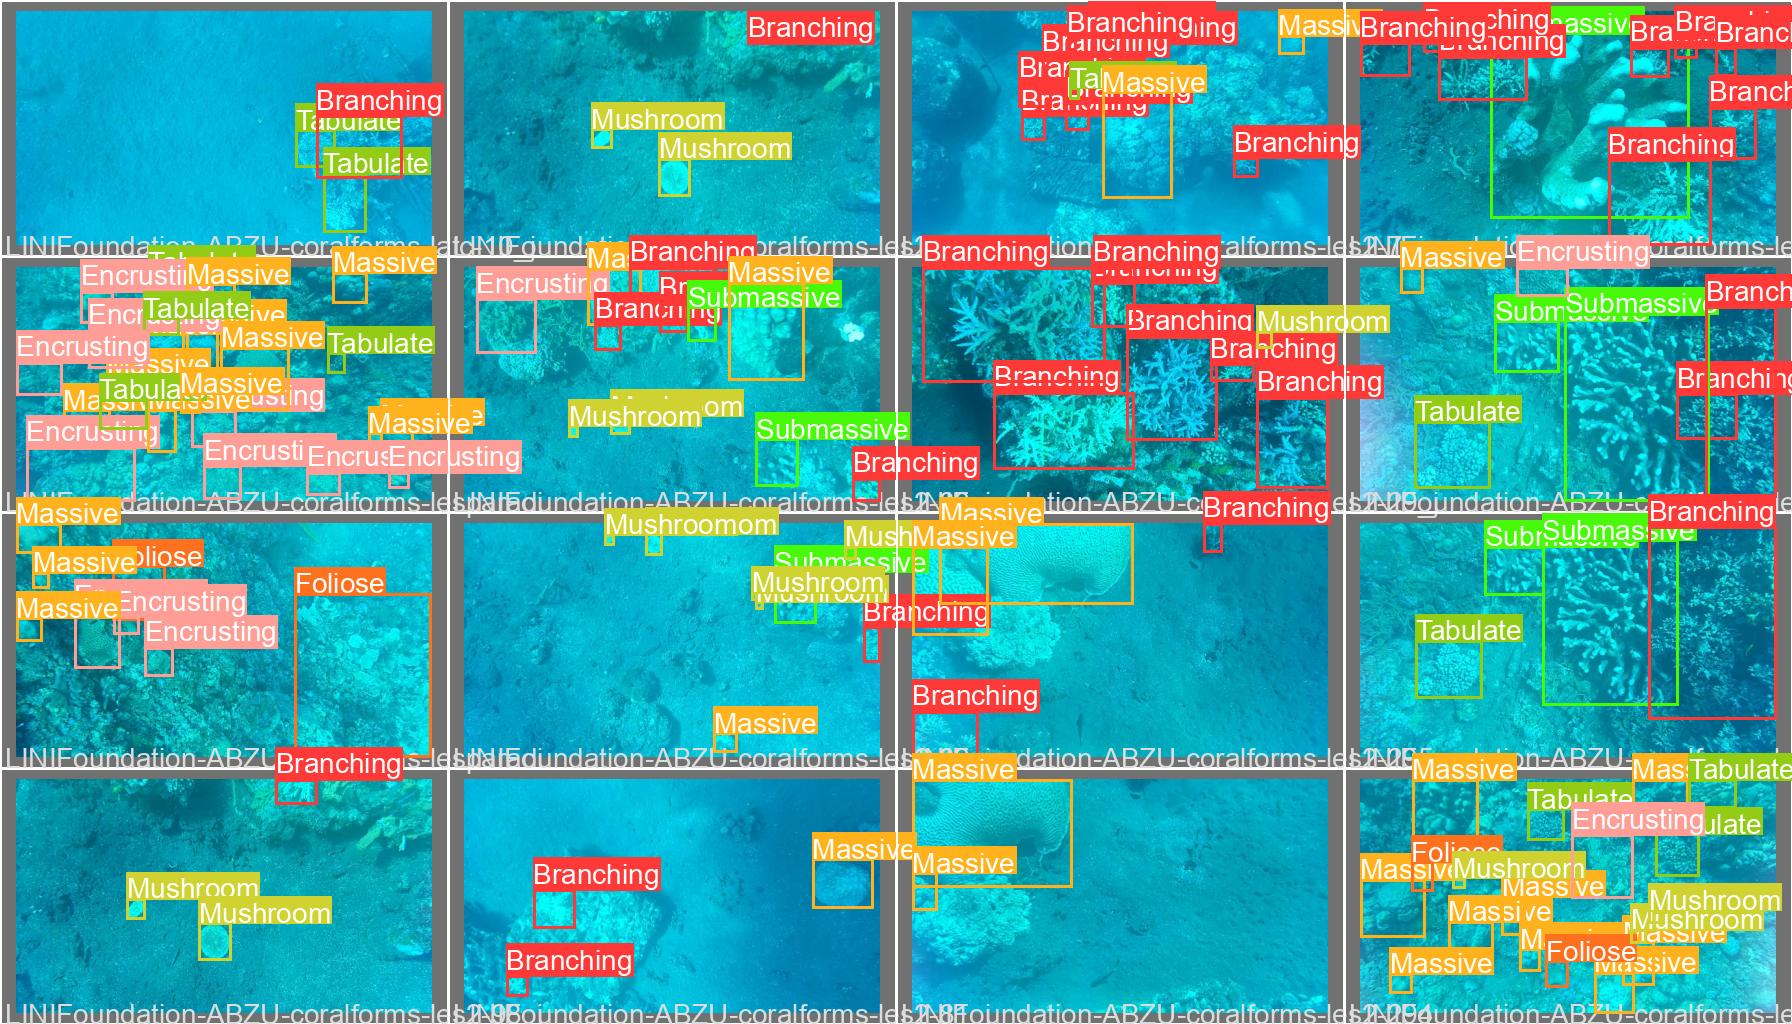

In [17]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


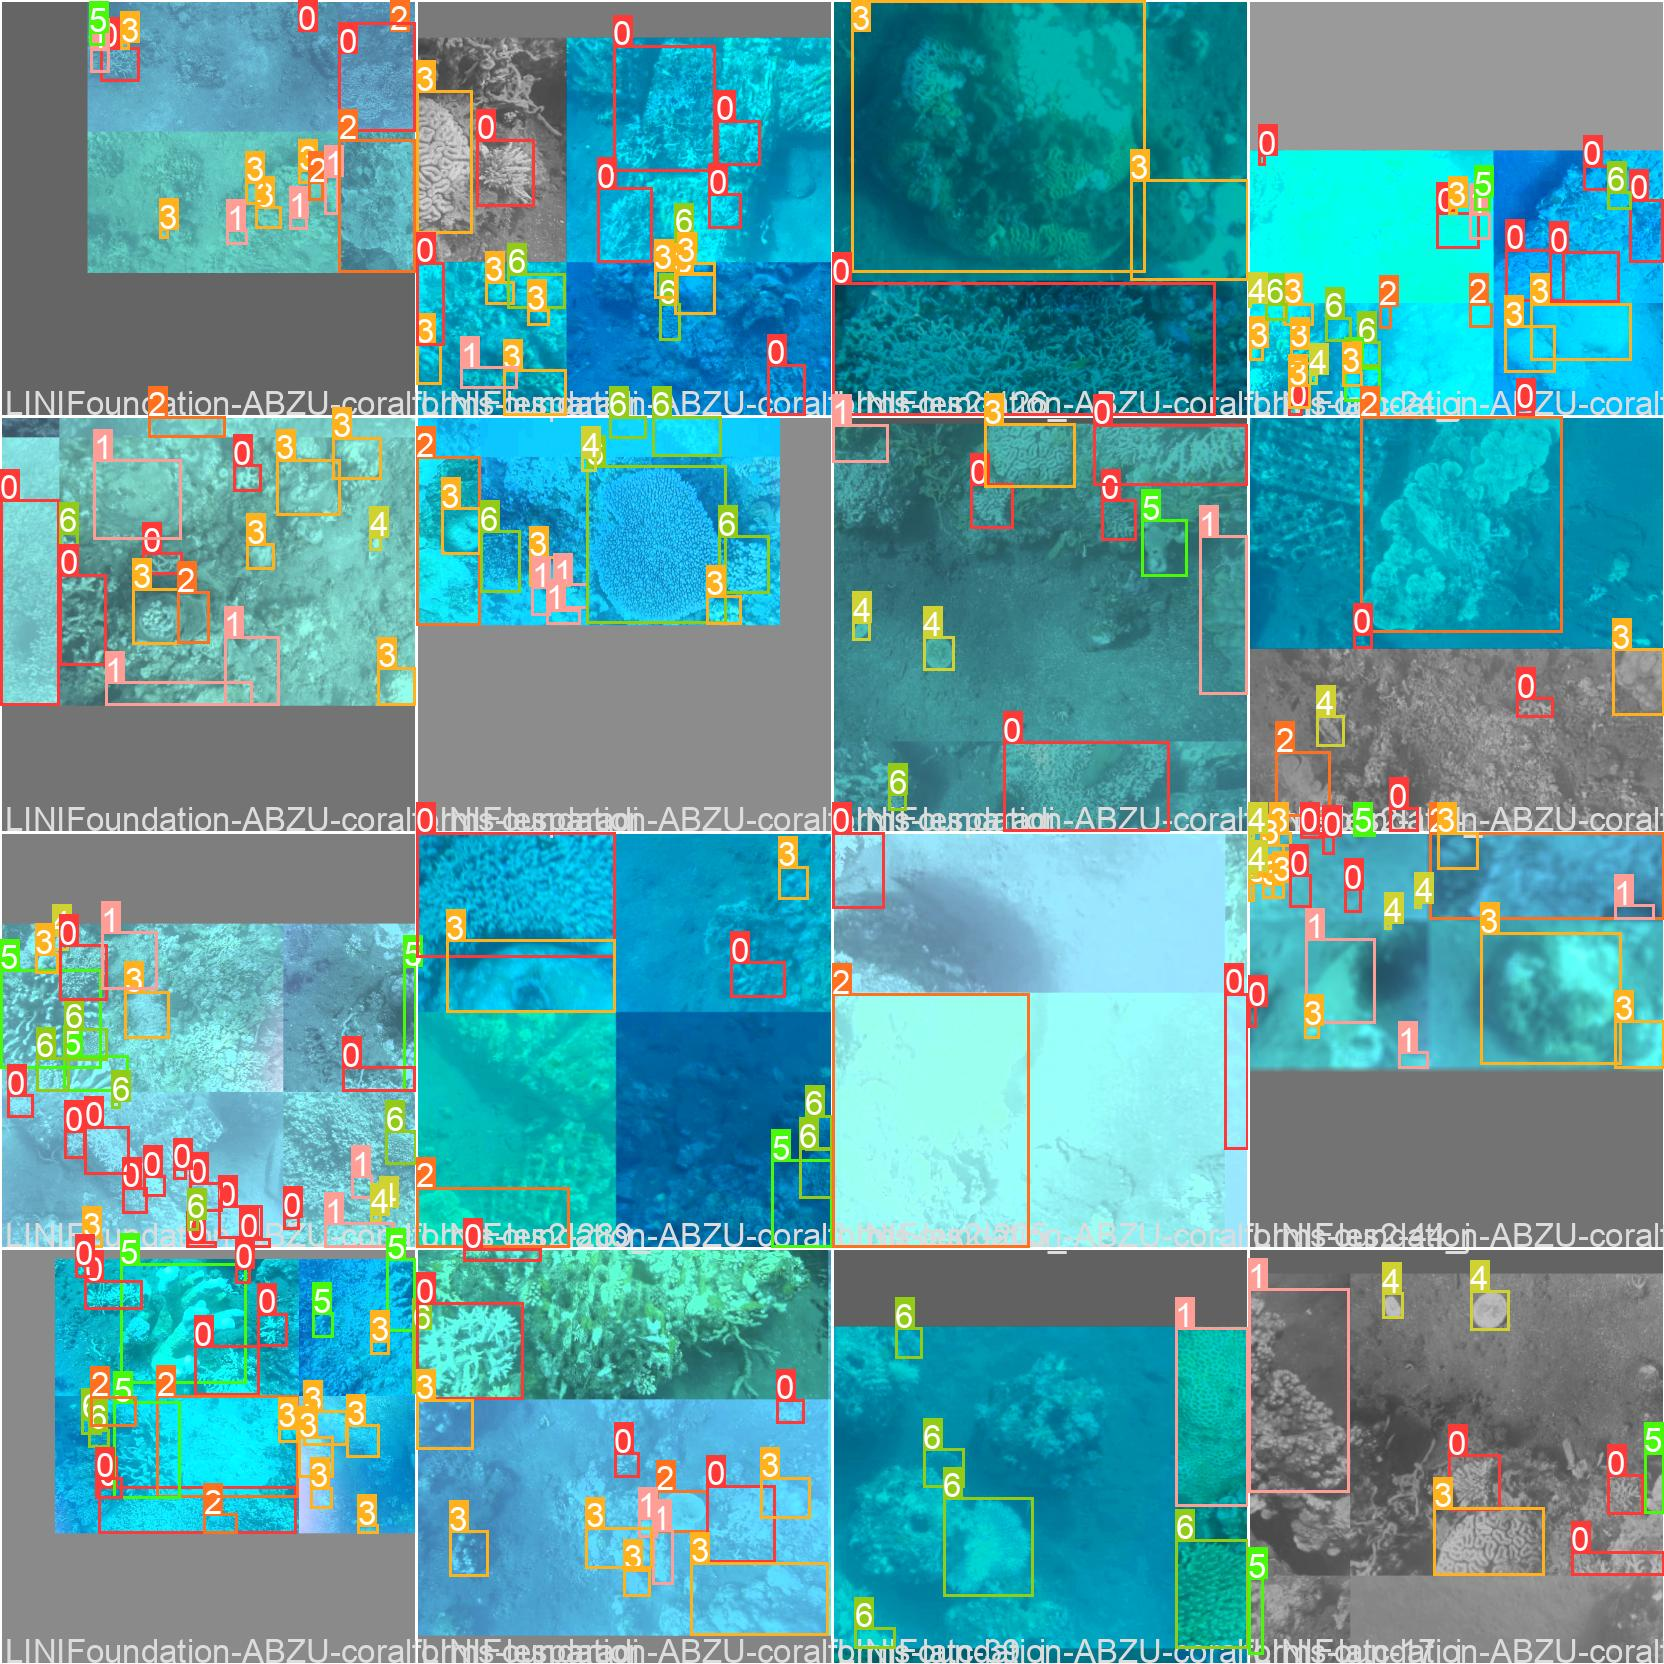

In [18]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

CONFUSION MATRIX:


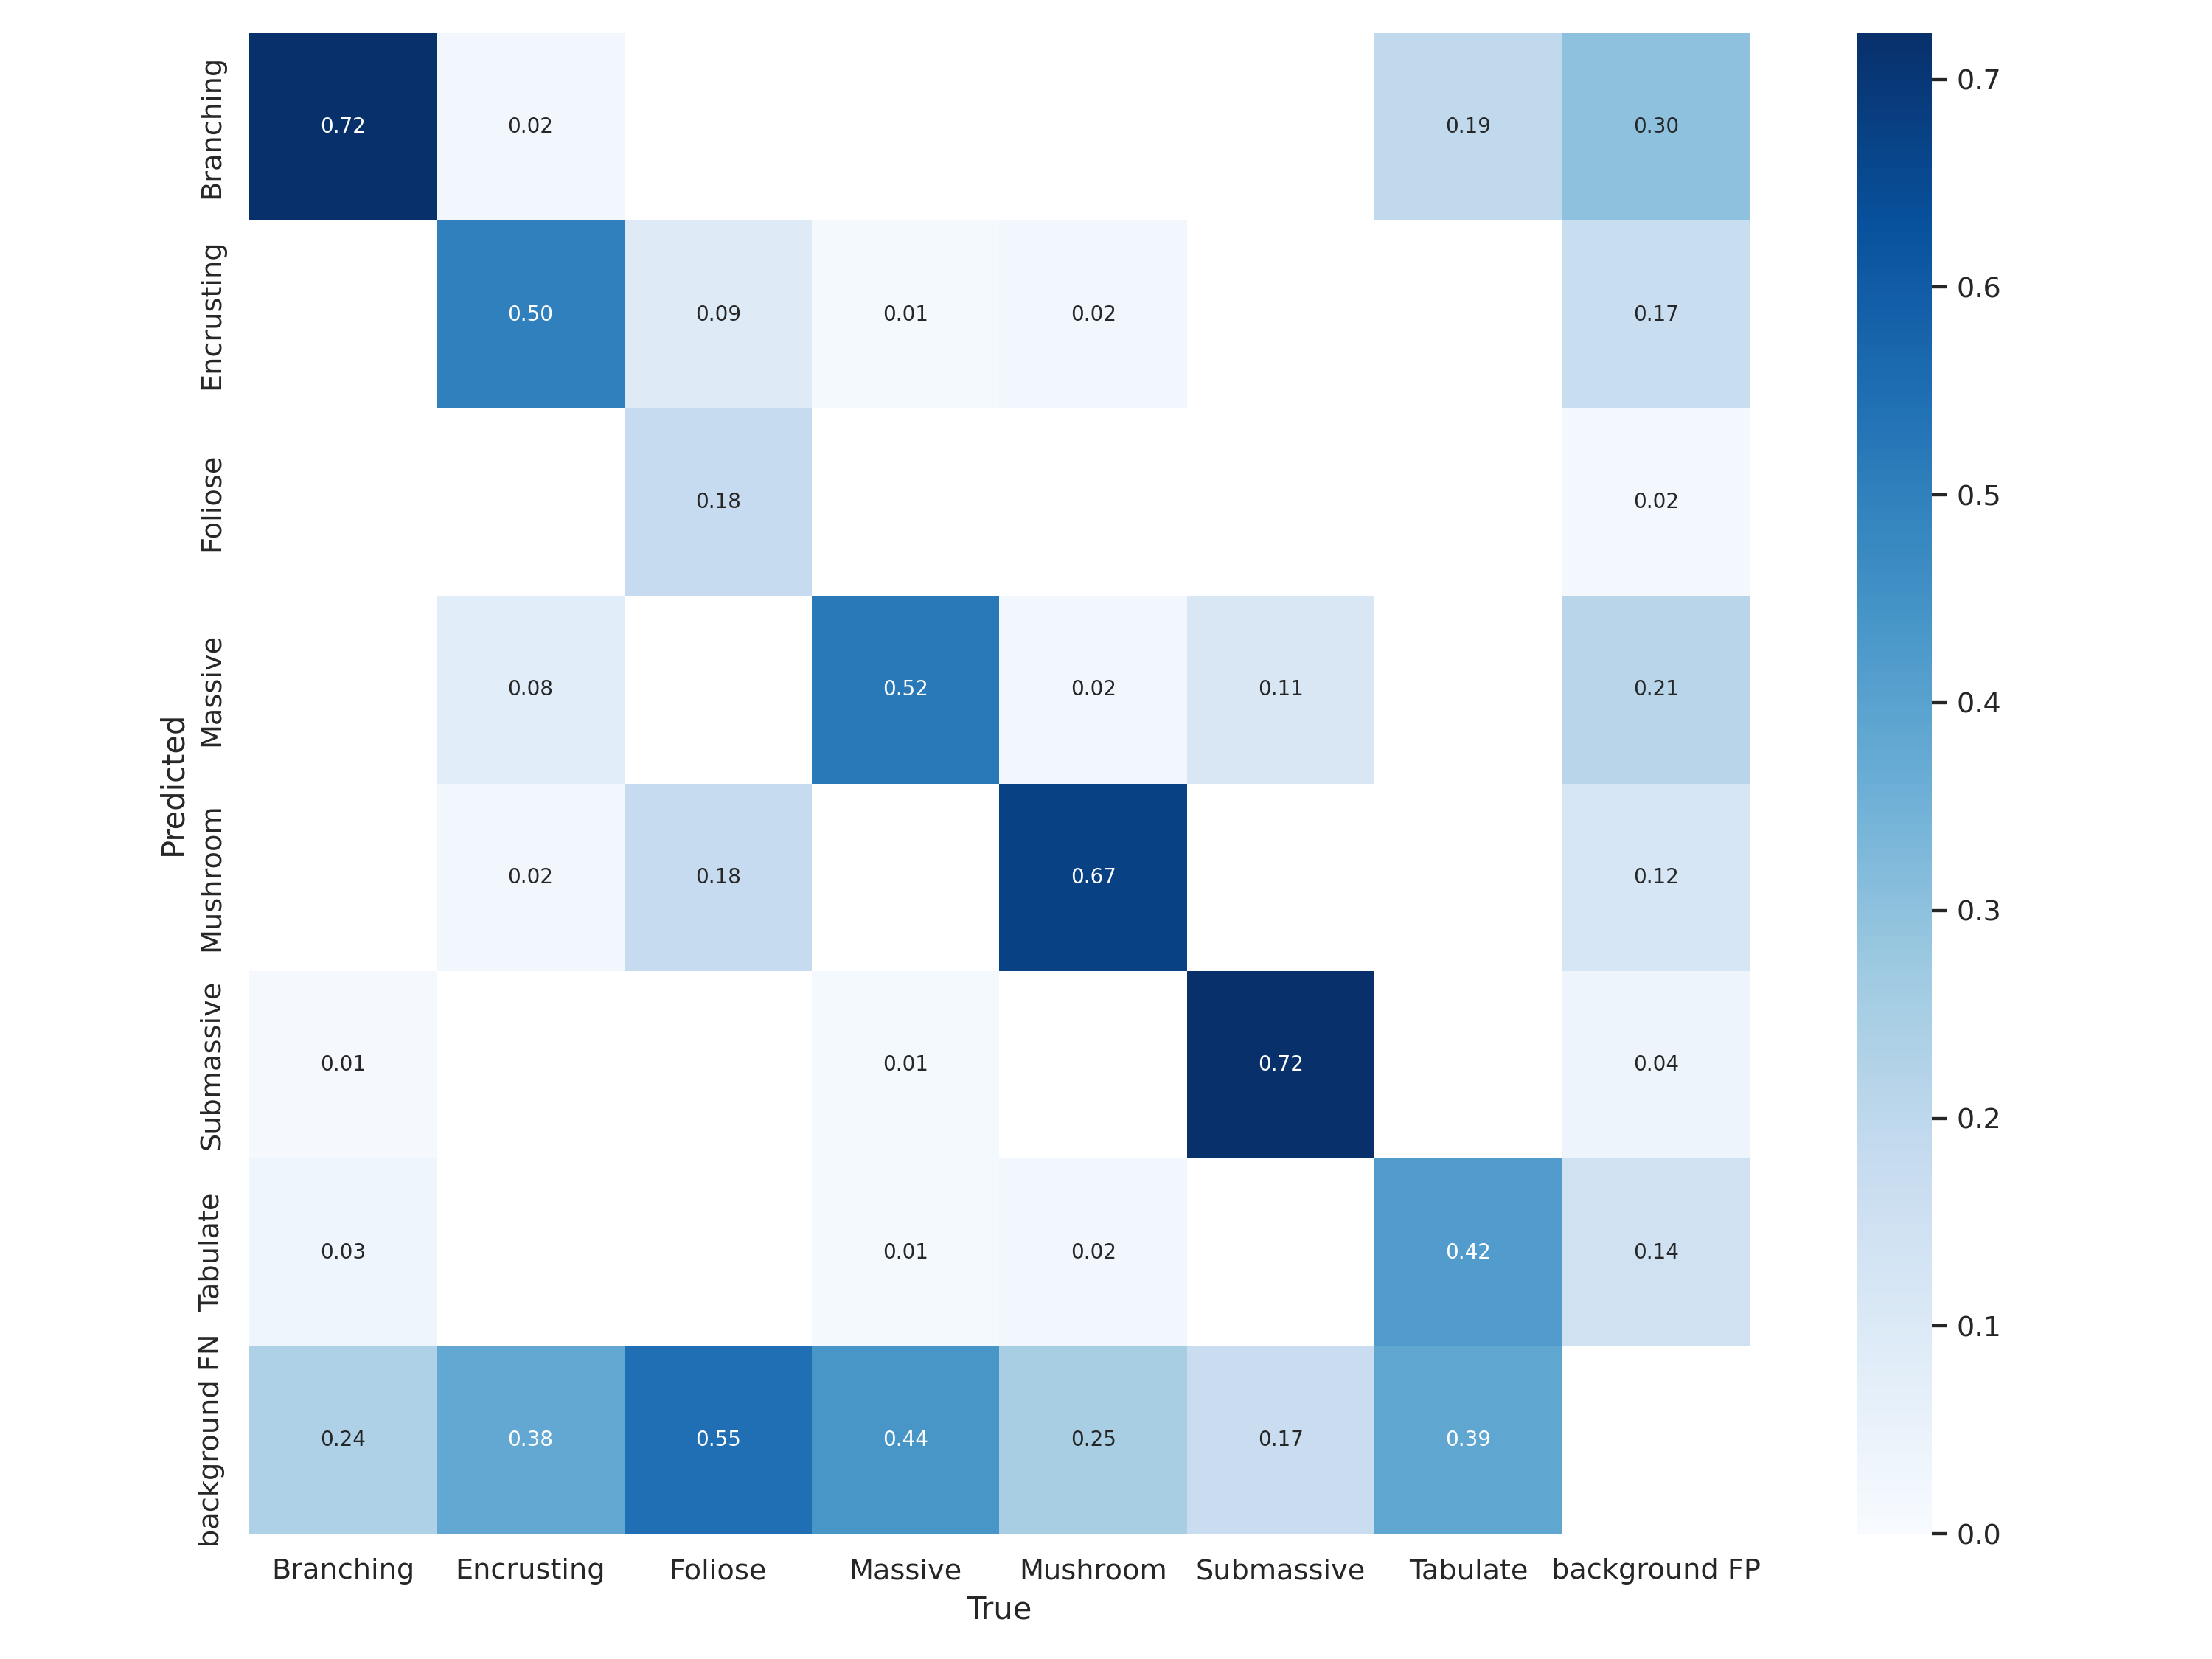

In [19]:
# print out the confusion matrix
print("CONFUSION MATRIX:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/confusion_matrix.png', width=900)

Validation Predict:


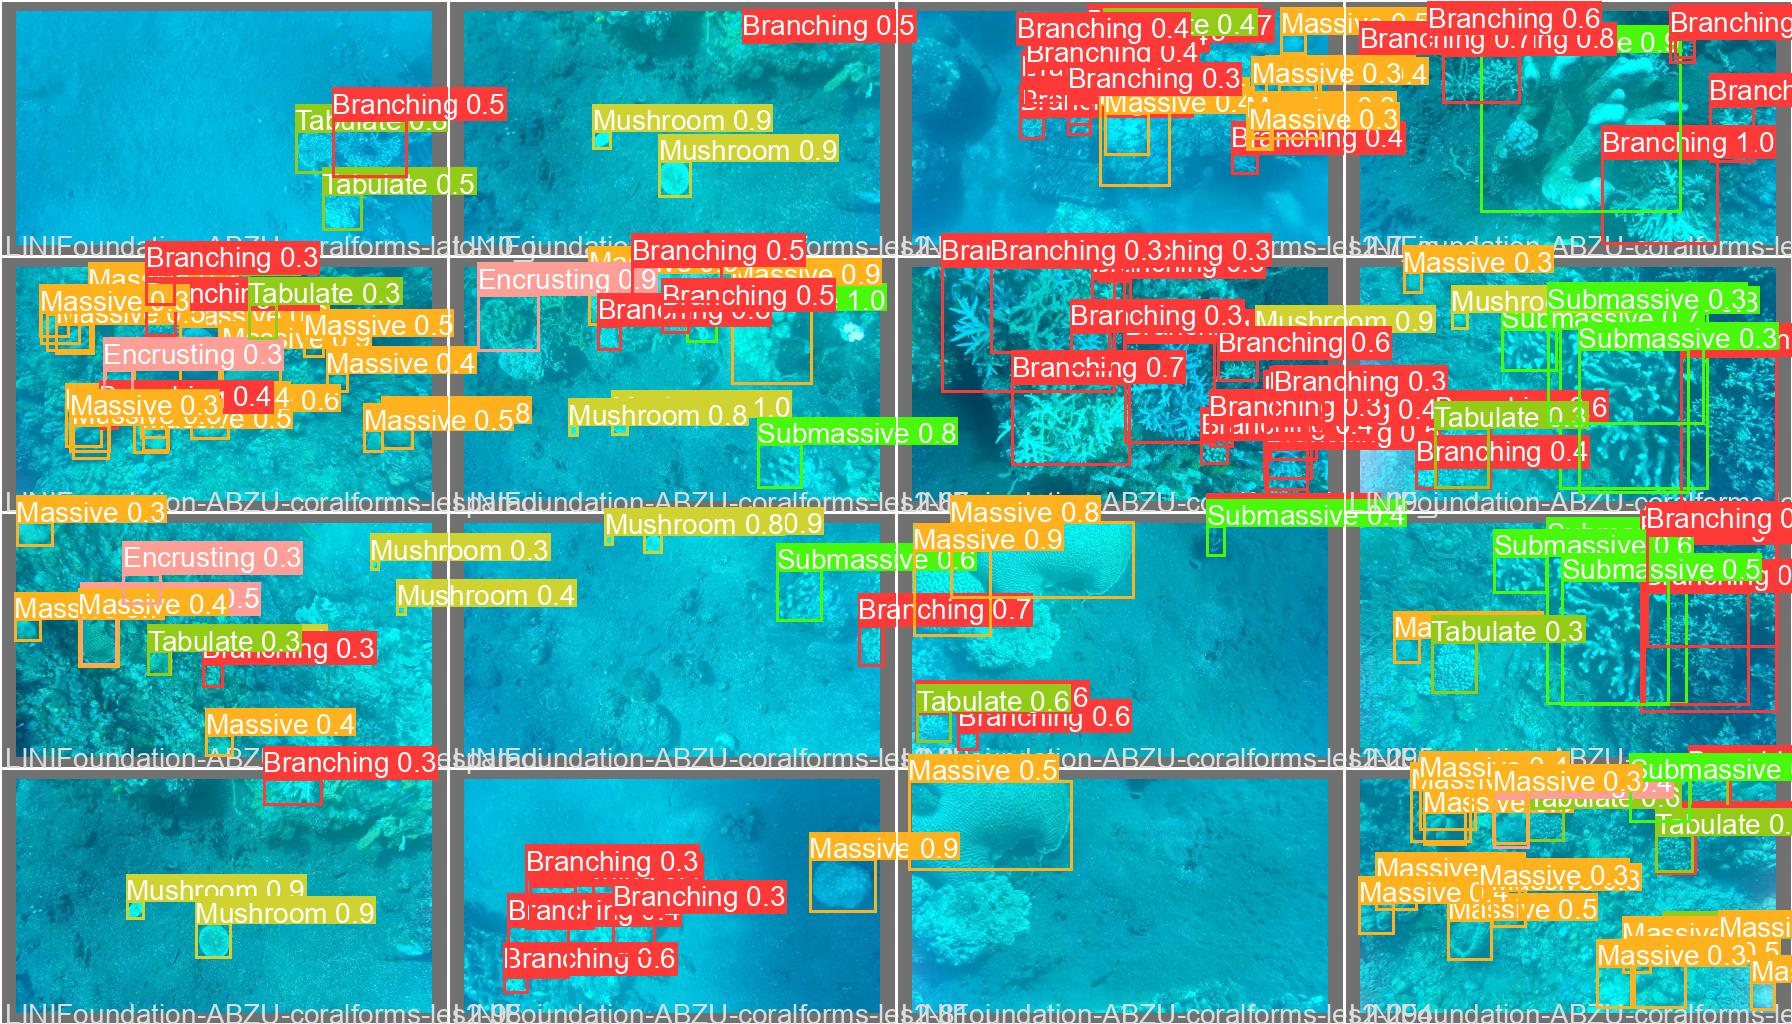

In [20]:
# print out the prediction
print("Validation Predict:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_pred.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [21]:
# trained weights are saved by default in our weights folder
%ls runs/

train/  val/


In [22]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [31]:

# use the best weights!
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/Coral-Life-Forms-Detection-3/test/images

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/Coral-Life-Forms-Detection-3/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e46 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7262700 parameters, 0 gradients, 16.8 GFLOPs
image 1/33 /content/yolov5/Coral-Life-Forms-Detection-3/test/images/LINIFoundation-ABZU-coralforms-latc-11_jpg.rf.a917bf401fd732b05242c05c6f4d3748.jpg: 256x416 3 Branchings, Done. (0.053s)
image 2/33 /content/yolov5/Coral-Life-Forms-Detection-3/test/images/LINIFoundati

In [24]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# print out the test prediction
#print("Test Predict:")
#Image(filename='/content/yolov5/runs/detect/exp2/LINIFoundation-ABZU-coralforms-les2-108_jpg.rf.67a01f95ec7eb839fa2e311290f1afe9.jpg', width=900)

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov

Streaming output truncated to the last 5000 lines.
video 1/1 (298/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 4 Branchings, 1 Tabulate, Done. (0.014s)
video 1/1 (299/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 3 Branchings, 1 Tabulate, Done. (0.013s)
video 1/1 (300/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 3 Branchings, Done. (0.013s)
video 1/1 (301/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 3 Branchings, Done. (0.016s)
video 1/1 (302/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 2 Branchings, 1 Tabulate, Done. (0.014s)
video 1/1 (303/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 2 Branchings, 1 Tabulate, Done. (0.018s)
video 1/1 (304/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 3 Branchings, 1 Tabulate, Done. (0.010s)
video 1/1 (305/5295) /content/gdrive/MyDrive/abzu-oakd-record/les2-1.mov: 256x416 3 Branchings, 1 Tabulate, Done

In [ ]:
%cp /content/yolov5/runs/detect/exp3/les2-1.mp4 /content/gdrive/MyDrive/AI_bootcamp

In [28]:
%cp /content/yolov5/runs/train/yolov5s_results2/weights/best.pt /content/gdrive/MyDrive/AI_bootcamp